### Binary Classification Model for Kaggle Tabular Playground Series Apr 2021 Using Python and Scikit-Learn
### David Lowe
### June 10, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Kaggle Tabular Playground Apr 2021 dataset is a binary classification situation where we attempt to predict one of the two possible outcomes.

INTRODUCTION: Kaggle wants to provide an approachable environment for relatively new people in their data science journey. Since January 2021, they have hosted playground-style competitions on Kaggle with fun but less complex, tabular datasets. The dataset used for this competition is synthetic but based on the real Titanic dataset and generated using a CTGAN. The statistical properties of this dataset are very similar to the original Titanic dataset, but there is no shortcut to cheat by using public labels for predictions.

ANALYSIS: The average performance of the machine learning algorithms achieved an accuracy benchmark of 0.7253 using the training dataset. We selected k-Nearest Neighbors and Random Forest to perform the tuning exercises. After a series of tuning trials, the refined k-Nearest Neighbors model processed the training dataset with a final accuracy score of 0.7699. When we processed Kaggle's test dataset with the final model, the model achieved an accuracy score of 0.7780.

CONCLUSION: In this iteration, the k-Nearest Neighbors model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Kaggle Tabular Playground 2021 Apr Data Set

Dataset ML Model: Binary classification with numerical and categorical attributes

Dataset Reference: https://www.kaggle.com/c/tabular-playground-series-apr-2021

One potential source of performance benchmark: https://www.kaggle.com/c/tabular-playground-series-apr-2021/leaderboard

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Pre-process Data
4. Train and Evaluate Models
5. Fine-tune and Improve Models
6. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# Retrieve the GPU information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [3]:
# Retrieve the memory configuration from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [4]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


### 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
from datetime import datetime
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

### 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 2

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.25

# Set the number of folds for cross validation
N_FOLDS = 5

# Set various default modeling parameters
SCORING_METRIC = 'accuracy'

In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [10]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021apr/train.csv'
df_dataset_import = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   PassengerId  Survived  Pclass              Name   Sex    Age  SibSp  Parch  \
0            0         1       1  Oconnor, Frankie  male    NaN      2      0   
1            1         0       3       Bryan, Drew  male    NaN      0      0   
2            2         0       3    Owens, Kenneth  male   0.33      1      2   
3            3         0       3     Kramer, James  male  19.00      0      0   
4            4         1       3     Bond, Michael  male  25.00      0      0   

      Ticket   Fare   Cabin Embarked  
0     209245  27.14  C12239        S  
1      27323  13.35     NaN        S  
2  CA 457703  71.29     NaN        S  
3   A. 10866  13.04     NaN        S  
4     427635   7.76     NaN        S  


In [11]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  100000 non-null  int64  
 1   Survived     100000 non-null  int64  
 2   Pclass       100000 non-null  int64  
 3   Name         100000 non-null  object 
 4   Sex          100000 non-null  object 
 5   Age          96708 non-null   float64
 6   SibSp        100000 non-null  int64  
 7   Parch        100000 non-null  int64  
 8   Ticket       95377 non-null   object 
 9   Fare         99866 non-null   float64
 10  Cabin        32134 non-null   object 
 11  Embarked     99750 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 9.2+ MB


In [12]:
print(df_dataset_import.describe())

         PassengerId       Survived         Pclass           Age  \
count  100000.000000  100000.000000  100000.000000  96708.000000   
mean    49999.500000       0.427740       2.106910     38.355472   
std     28867.657797       0.494753       0.837727     18.313556   
min         0.000000       0.000000       1.000000      0.080000   
25%     24999.750000       0.000000       1.000000     25.000000   
50%     49999.500000       0.000000       2.000000     39.000000   
75%     74999.250000       1.000000       3.000000     53.000000   
max     99999.000000       1.000000       3.000000     87.000000   

               SibSp          Parch         Fare  
count  100000.000000  100000.000000  99866.00000  
mean        0.397690       0.454560     43.92933  
std         0.862566       0.950076     69.58882  
min         0.000000       0.000000      0.68000  
25%         0.000000       0.000000     10.04000  
50%         0.000000       0.000000     24.46000  
75%         1.000000       1.0

In [13]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age             3292
SibSp              0
Parch              0
Ticket          4623
Fare             134
Cabin          67866
Embarked         250
dtype: int64
Total number of NaN in the dataframe:  76165


### 1.d) Data Cleaning

In [14]:
# Dropping features
df_dataset_import.drop(columns=['PassengerId','Name','Ticket','Cabin'], inplace=True)

# Convert columns from one data type to another
df_dataset_import['Pclass'] = df_dataset_import['Pclass'].astype('category')

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

   Survived Pclass   Sex    Age  SibSp  Parch   Fare Embarked
0         1      1  male    NaN      2      0  27.14        S
1         0      3  male    NaN      0      0  13.35        S
2         0      3  male   0.33      1      2  71.29        S
3         0      3  male  19.00      0      0  13.04        S
4         1      3  male  25.00      0      0   7.76        S


In [15]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   Survived  100000 non-null  int64   
 1   Pclass    100000 non-null  category
 2   Sex       100000 non-null  object  
 3   Age       96708 non-null   float64 
 4   SibSp     100000 non-null  int64   
 5   Parch     100000 non-null  int64   
 6   Fare      99866 non-null   float64 
 7   Embarked  99750 non-null   object  
dtypes: category(1), float64(2), int64(3), object(2)
memory usage: 5.4+ MB


In [16]:
print(df_dataset_import.describe())

            Survived           Age          SibSp          Parch         Fare
count  100000.000000  96708.000000  100000.000000  100000.000000  99866.00000
mean        0.427740     38.355472       0.397690       0.454560     43.92933
std         0.494753     18.313556       0.862566       0.950076     69.58882
min         0.000000      0.080000       0.000000       0.000000      0.68000
25%         0.000000     25.000000       0.000000       0.000000     10.04000
50%         0.000000     39.000000       0.000000       0.000000     24.46000
75%         1.000000     53.000000       1.000000       1.000000     33.50000
max         1.000000     87.000000       8.000000       9.000000    744.66000


In [17]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

Survived       0
Pclass         0
Sex            0
Age         3292
SibSp          0
Parch          0
Fare         134
Embarked     250
dtype: int64
Total number of NaN in the dataframe:  3676


### 1.e) Splitting Data into Sets

In [18]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# target_column_position variable indicates the column location of the target/class variable
# If the first column, set target_column_position to 1. If the last column, set target_column_position to total_column_count
# If (target_column_position <> 1) and (target_column_position <> total_column_count), be aware when slicing up the dataframes for visualization
target_column_position = 1

In [19]:
# We create attribute-only and target-only datasets (df_features_train and df_target_train)
# for various visualization and cleaning/transformation operations

if target_column_position == total_column_count:
    df_features_train = df_dataset_import.iloc[:,0:total_feature_count]
    df_target_train = df_dataset_import.iloc[:,total_feature_count]
else:
    df_features_train = df_dataset_import.iloc[:,1:total_column_count]
    df_target_train = df_dataset_import.iloc[:,0]

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (100000, 8) df_features_train.shape: (100000, 7) df_target_train.shape: (100000,)


### 1.f) Set up the parameters for data visualization

In [20]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [21]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [22]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

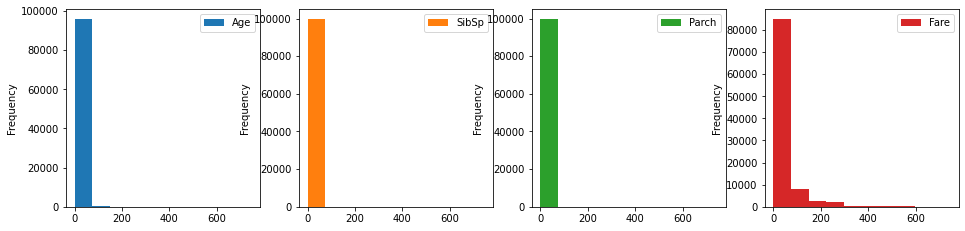

In [23]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

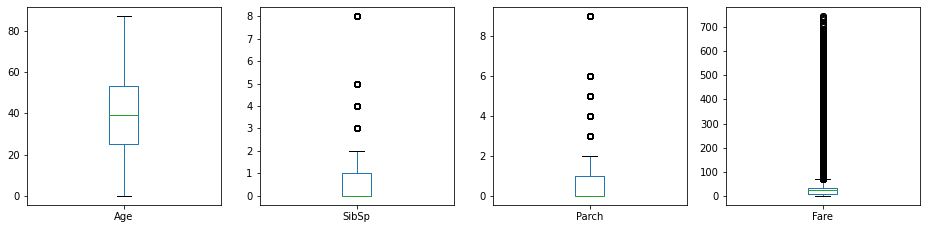

In [24]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

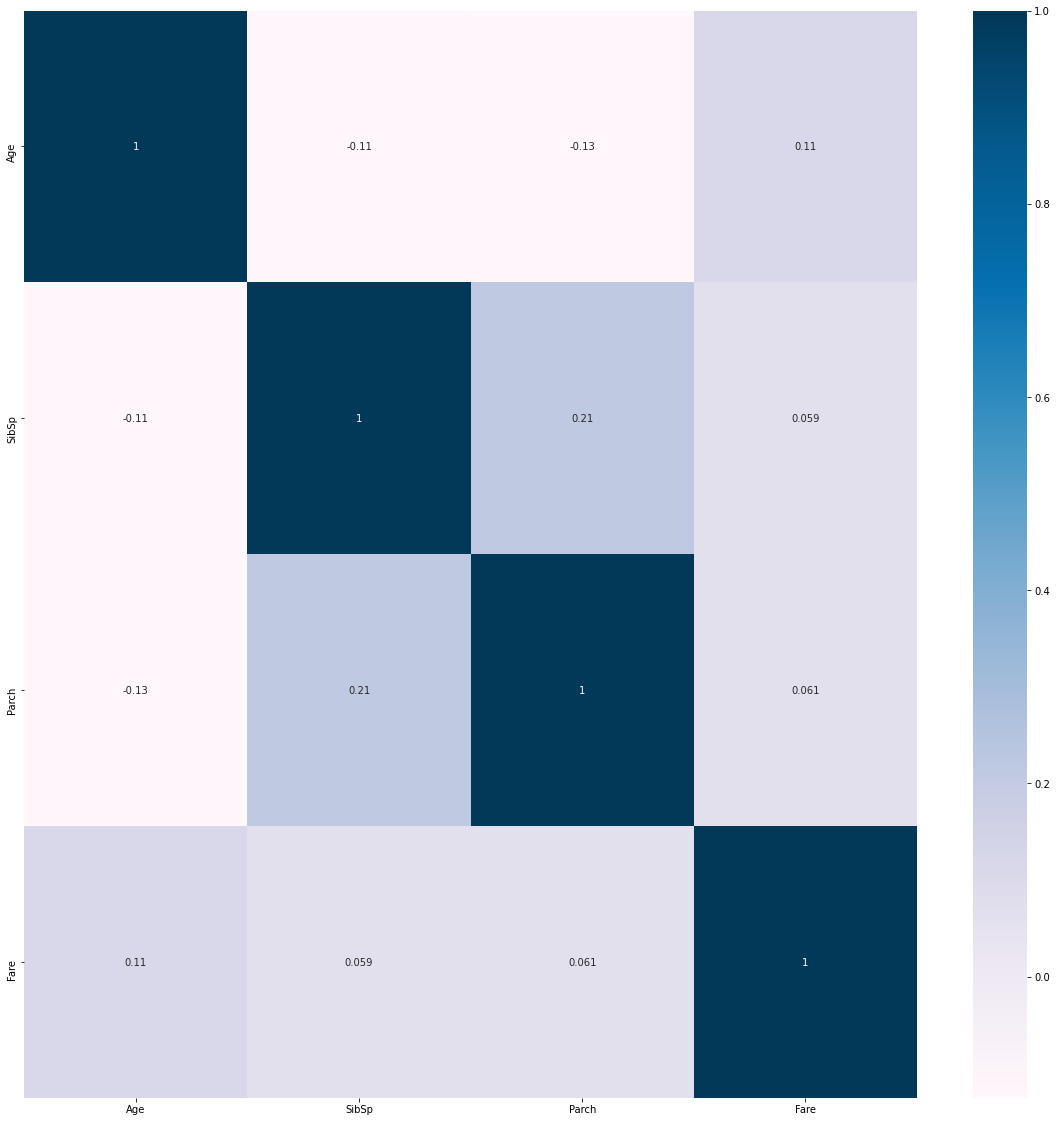

In [25]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [26]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [27]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Test Sets

In [28]:
# Not applicable for this iteration of the project

### 3.b) Feature Scaling and Data Pre-Processing

In [29]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['int64','float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy="median")),
    ('scaler', preprocessing.MinMaxScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool','category']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UKNOWN')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 4
Number of categorical columns: 3
Total number of columns in the feature dataframe: 7


In [30]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Display the shapes of the training dataset for final inspection
array_features_train = preprocessor.fit_transform(df_features_train)
print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

Transformed features from df_features_train.shape: (100000, 7) to array_features_train.shape: (100000, 13)


### 3.c) Training Data Balancing

In [31]:
# Not applicable for this iteration of the project

### 3.d) Feature Selection

In [32]:
# Not applicable for this iteration of the project

### 3.e) Display the Final Datasets for Model-Building

In [33]:
# Finalize the training and validation datasets for the modeling activities
# array_features_train = df_features_train.to_numpy()
array_target_train = df_target_train.ravel()
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (100000, 13) array_target_train.shape: (100000,)


In [34]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Evaluate Models

In [35]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [36]:
# Set up Algorithms Spot-Checking Array
start_time_training = datetime.now()
start_time_module = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []
train_models.append(('LGR', LogisticRegression(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('CART', DecisionTreeClassifier(random_state=RNG_SEED)))
train_models.append(('KNN', KNeighborsClassifier(n_jobs=N_JOBS)))
train_models.append(('BGT', BaggingClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('RNF', RandomForestClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('EXT', ExtraTreesClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))

In [37]:
# Generate model in turn
for name, model in train_models:
	if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	start_time_module = datetime.now()
	kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
	cv_results = cross_val_score(model, array_features_train, array_target_train, cv=kfold, scoring=SCORING_METRIC, n_jobs=N_JOBS, verbose=1)
	train_results.append(cv_results)
	train_model_names.append(name)
	train_metrics.append(cv_results.mean())
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - start_time_module), '\n')
	if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics ('+SCORING_METRIC+') from all models:',np.mean(train_metrics))
print ('Total training time for all models:',(datetime.now() - start_time_training))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    5.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


LGR: 0.764250 (0.001620)
LogisticRegression(n_jobs=2, random_state=888)
Model training time: 0:00:05.897318 



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    2.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


CART: 0.686160 (0.001736)
DecisionTreeClassifier(random_state=888)
Model training time: 0:00:02.698987 



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.1min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


KNN: 0.741790 (0.001754)
KNeighborsClassifier(n_jobs=2)
Model training time: 0:01:03.384834 



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    8.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


BGT: 0.722380 (0.002241)
BaggingClassifier(n_jobs=2, random_state=888)
Model training time: 0:00:08.148747 



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   39.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


RNF: 0.727400 (0.001678)
RandomForestClassifier(n_jobs=2, random_state=888)
Model training time: 0:00:39.128635 

EXT: 0.710140 (0.000882)
ExtraTreesClassifier(n_jobs=2, random_state=888)
Model training time: 0:00:30.628209 

Average metrics (accuracy) from all models: 0.7253533333333334
Total training time for all models: 0:02:29.911173


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   30.5s finished


### 4.b) Spot-checking baseline algorithms

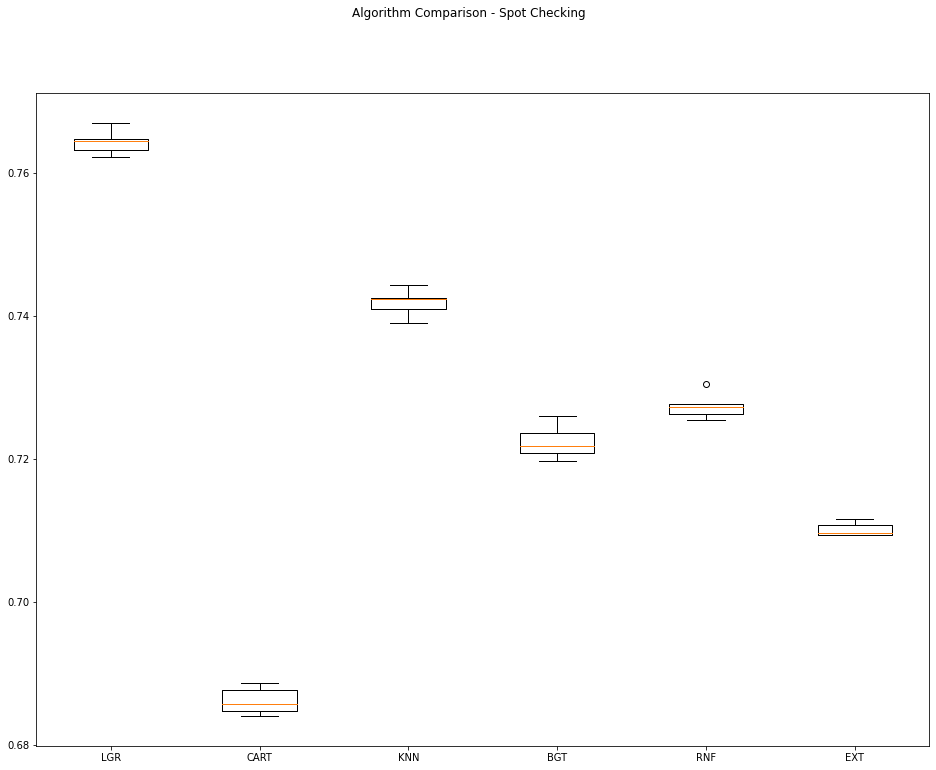

In [38]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

In [39]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Fine-tune and Improve Models

In [40]:
if NOTIFY_STATUS: status_notify("Task 5 - Fine-tune and Improve Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Algorithm Tuning

In [41]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [42]:
# Tuning algorithm #1 - Extra Trees
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm #1 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = KNeighborsClassifier(n_jobs=N_JOBS)
tune_model_names.append('KNN')
paramGrid1 = dict(n_neighbors=np.array([5, 100, 200, 400]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result1 = grid1.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm #1 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best: 0.769910 using {'n_neighbors': 200}
0.741790 (0.001754) with: {'n_neighbors': 5}
0.769290 (0.002396) with: {'n_neighbors': 100}
0.769910 (0.002340) with: {'n_neighbors': 200}
0.768970 (0.001857) with: {'n_neighbors': 400}
Model training time: 0:05:14.904711


In [43]:
best_paramKey1 = list(grid_result1.best_params_.keys())[0]
best_paramValue1 = list(grid_result1.best_params_.values())[0]
print("Captured the best parameter for algorithm #1:", best_paramKey1, '=', best_paramValue1)

Captured the best parameter for algorithm #1: n_neighbors = 200


In [44]:
# Tuning algorithm #2 - Random Forest
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm #2 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = RandomForestClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)
tune_model_names.append('RNF')
paramGrid2 = dict(n_estimators=np.array([100, 250, 500, 750]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result2 = grid2.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm #2 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best: 0.727400 using {'n_estimators': 100}
0.727400 (0.001678) with: {'n_estimators': 100}
0.727040 (0.001380) with: {'n_estimators': 250}
0.726770 (0.000812) with: {'n_estimators': 500}
0.727060 (0.000745) with: {'n_estimators': 750}
Model training time: 0:09:33.145197


In [45]:
best_paramKey2 = list(grid_result2.best_params_.keys())[0]
best_paramValue2 = list(grid_result2.best_params_.values())[0]
print("Captured the best parameter for algorithm #2:", best_paramKey2, '=', best_paramValue2)

Captured the best parameter for algorithm #2: n_estimators = 100


### 5.b) Compare Algorithms After Tuning

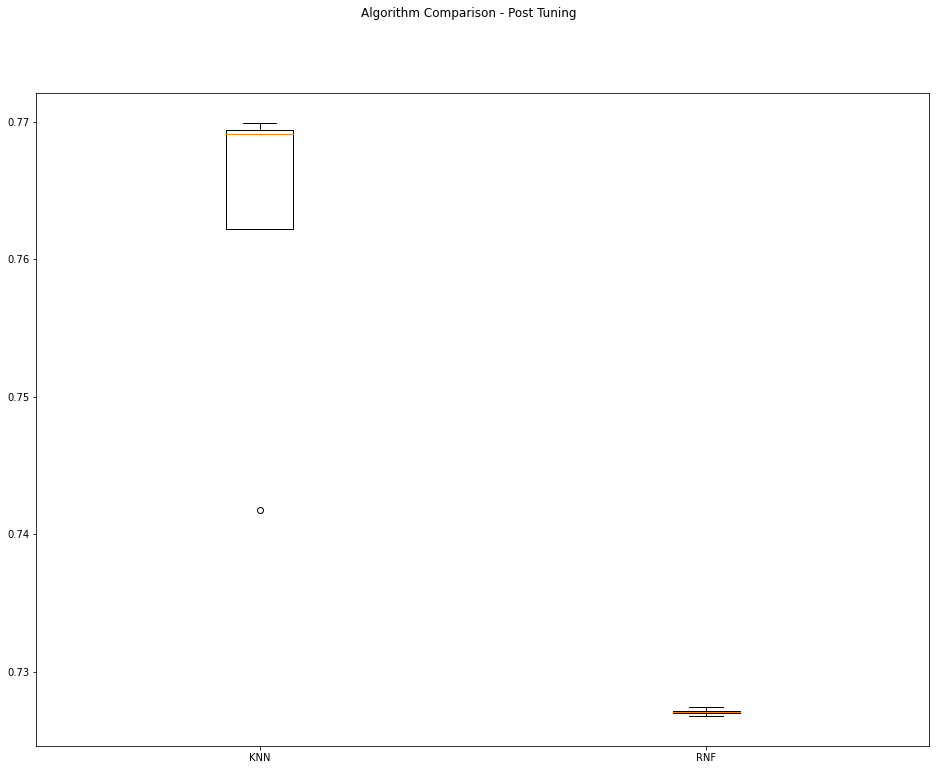

In [46]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [47]:
if NOTIFY_STATUS: status_notify("Task 5 - Fine-tune and Improve Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 6 - Finalize Model and Present Analysis

In [48]:
if NOTIFY_STATUS: status_notify("Task 6 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Train the Final Model

In [49]:
final_model = KNeighborsClassifier(n_neighbors=best_paramValue1, n_jobs=N_JOBS)
final_model.fit(array_features_train, array_target_train)
print(final_model)

KNeighborsClassifier(n_jobs=2, n_neighbors=200)


### 6.b) Load Test Dataset and Prepare the Submission File

In [50]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021apr/test.csv'
df_features_test = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_features_test.head())

   PassengerId  Pclass              Name     Sex   Age  SibSp  Parch  Ticket  \
0       100000       3  Holliday, Daniel    male  19.0      0      0   24745   
1       100001       3  Nguyen, Lorraine  female  53.0      0      0   13264   
2       100002       1   Harris, Heather  female  19.0      0      0   25990   
3       100003       2      Larsen, Eric    male  25.0      0      0  314011   
4       100004       1     Cleary, Sarah  female  17.0      0      2   26203   

    Fare   Cabin Embarked  
0  63.01     NaN        S  
1   5.81     NaN        S  
2  38.91  B15315        C  
3  12.93     NaN        S  
4  26.89  B22515        C  


In [51]:
df_kaggle_submission = pd.DataFrame()
df_kaggle_submission['PassengerId'] = df_features_test['PassengerId']
print(df_kaggle_submission.head())

   PassengerId
0       100000
1       100001
2       100002
3       100003
4       100004


In [52]:
# Dropping features
df_features_test.drop(columns=['PassengerId','Name','Ticket','Cabin'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_features_test.head())

   Pclass     Sex   Age  SibSp  Parch   Fare Embarked
0       3    male  19.0      0      0  63.01        S
1       3  female  53.0      0      0   5.81        S
2       1  female  19.0      0      0  38.91        C
3       2    male  25.0      0      0  12.93        S
4       1  female  17.0      0      2  26.89        C


In [53]:
# Finalize the test dataset for the modeling testing
array_features_test = preprocessor.transform(df_features_test)
print("Transformed features from df_features_test.shape: {} to array_features_test.shape: {}".format(df_features_test.shape, array_features_test.shape))

Transformed features from df_features_test.shape: (100000, 7) to array_features_test.shape: (100000, 13)


In [54]:
# Make batched predictions
test_predictions = final_model.predict(array_features_test)
print(test_predictions)

[0 1 1 ... 0 1 1]


In [55]:
df_kaggle_submission['Survived'] = test_predictions
print(df_kaggle_submission.head())

   PassengerId  Survived
0       100000         0
1       100001         1
2       100002         1
3       100003         0
4       100004         1


In [56]:
submission_file = df_kaggle_submission.to_csv(header=True, index=False)
filename = 'submission_' + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_20210607-1624.csv


In [57]:
if NOTIFY_STATUS: status_notify("Task 6 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [58]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 0:19:00.992149
